In [89]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io
from scipy.ndimage import rotate
from scipy.linalg import norm
from scipy.ndimage import zoom


In [90]:
def compute_complex_moments(image, p, q):
    """ Compute complex moments for the image with translation invariance (center of mass). """
    rows, cols = image.shape

    # Compute center of mass (translation invariance)
    y, x = np.indices((rows, cols))
    m00 = np.sum(image)  # Sum of image intensity
    m10 = np.sum(x * image)  # First moment along x
    m01 = np.sum(y * image)  # First moment along y
    x_bar = m10 / m00  # Center of mass x
    y_bar = m01 / m00  # Center of mass y

    # Shift coordinates to center of mass
    X_shifted = x - x_bar
    Y_shifted = y - y_bar

    # Compute complex moments
    return np.sum((X_shifted + 1j * Y_shifted)**p * image * (X_shifted - 1j * Y_shifted)**q)



def compute_flusser_moment(image, p, q, p0 = 5):
    """ Compute Flusser's rotation invariants for an image using the correct formula. """

    # Compute normalization moment: c_f(p0 - 1, p0)
    normalization_moment = compute_complex_moments(image, p0 - 1, p0)

    # Compute the Flusser invariant for any desired (p, q)

    moment = compute_complex_moments(image, p, q)

    invariant = (normalization_moment**(p - q)) * moment


    return invariant


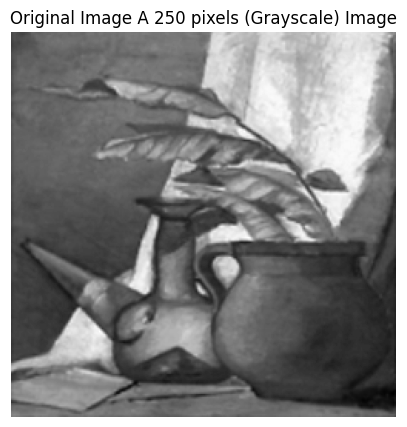

(1.5281299956061207e+21-32.24387980432695j)


In [91]:
image = io.imread('Image_A_250.png', as_gray=True)
plt.figure(figsize=(5, 5))
plt.title("Original Image A 250 pixels (Grayscale) Image")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

print(compute_flusser_moment(image, 4, 4))


Rotation Invariance : with Jan Flusser formulas

In [122]:
def compute_flusser_invariants_for_orders(image, rotation_angles, max_order=14):

    original_flusser_invariants = [compute_flusser_moment(image, p, p) for p in range(1, max_order + 1)]

    errors_flusser = {order: [] for order in range(1, max_order + 1)}
    rotated_images = []

    for angle in rotation_angles:

        rotated_image = rotate(image, angle, reshape=True, mode='constant', cval=0)
        rotated_images.append(rotated_image)

        for order in range(1, max_order + 1):
            invariant_order_rotated = compute_flusser_moment(rotated_image, order, order)
            original_invariant = original_flusser_invariants[order - 1]

            relative_error = np.abs((original_invariant - invariant_order_rotated) / original_invariant)
            errors_flusser[order].append(relative_error)

    return errors_flusser, rotated_images


Relative Error graphs : 5 rotations with Flusser invariants

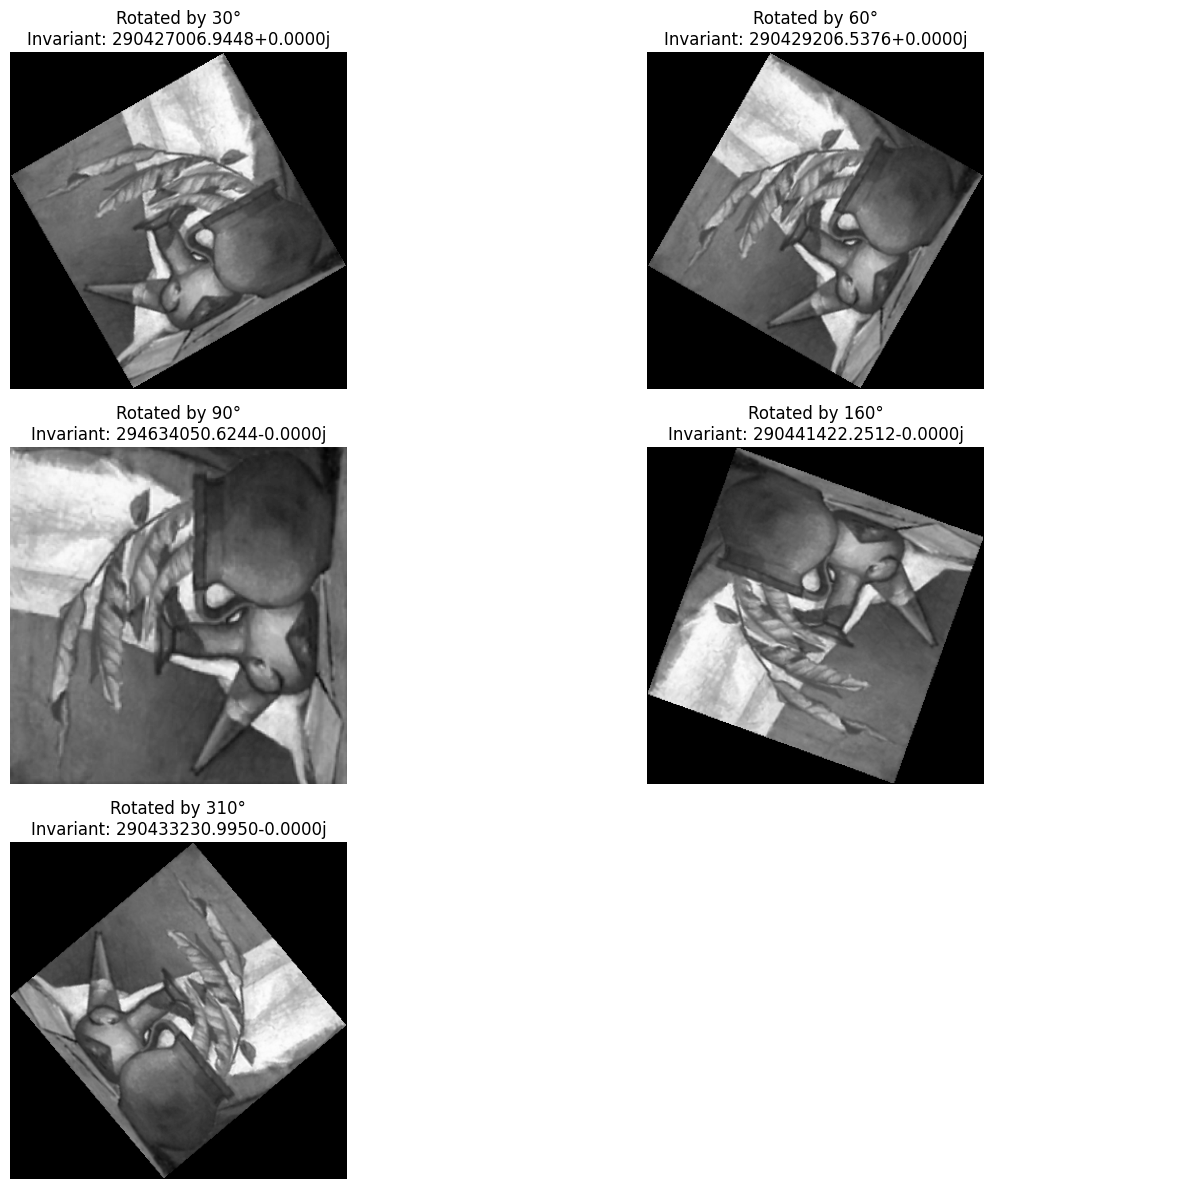

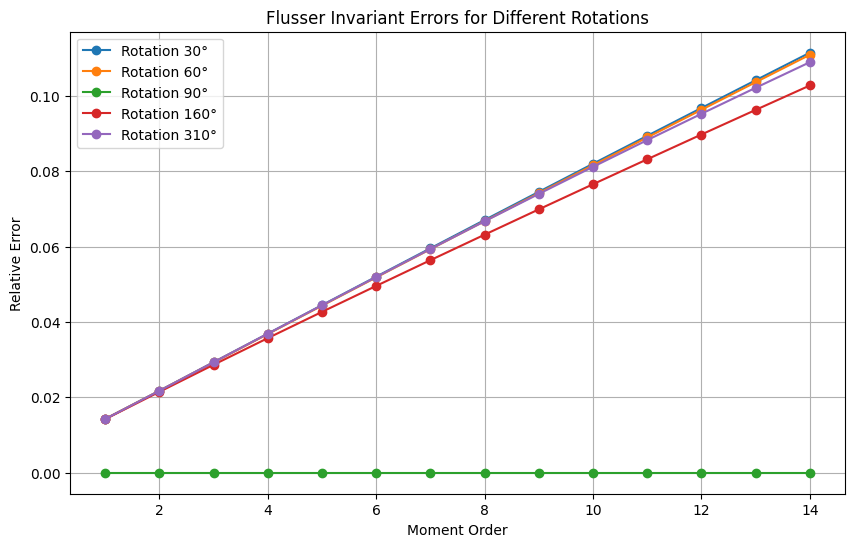

In [94]:
def plot_flusser_invariant_errors_and_images(flusser_errors, rotation_angles, rotated_images, image):
    """
    Plot the relative errors of Flusser invariants for each rotation angle with respect to moment orders,
    and display the rotated images along with their invariant values.

    Args:
        flusser_errors: A dictionary of relative errors for each order (output of `compute_flusser_invariants_for_orders`).
        rotation_angles: A list of rotation angles (degrees) to be plotted as separate lines.
        rotated_images: The list of rotated images to display.
        image: The original image to compute the invariant.
    """
    # Prepare x-axis (orders) based on the keys in the `flusser_errors` dictionary
    orders = list(flusser_errors.keys())  # Moment orders

    # Create a figure for images and graphs, adjusting the number of rows based on the number of angles
    num_angles = len(rotation_angles)
    rows = (num_angles + 1) // 2  # Calculate the number of rows needed
    fig, axs = plt.subplots(rows, 2, figsize=(14, 12))  # 2 columns

    # Flatten axs for easy indexing
    axs = axs.flatten()

    # Store invariant values for each rotation angle
    invariants_rotated = []

    # Plot the rotation angles and their corresponding rotated images
    for i, angle in enumerate(rotation_angles):
        # Rotate the image by the given angle with padding (black background)
        rotated_image = rotated_images[i]

        # Compute the Flusser invariant for the rotated image
        invariant_rotated = compute_flusser_moment(rotated_image, 1, 1)  # Example for order 1
        invariants_rotated.append(invariant_rotated)

        # Display rotated images in subplots with Flusser invariant values
        axs[i].imshow(rotated_image, cmap='gray')
        axs[i].set_title(f'Rotated by {angle}°\nInvariant: {invariant_rotated:.4f}')
        axs[i].axis('off')

    # Hide any remaining empty subplots
    for j in range(num_angles, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Create a figure for the error graphs (5 rotations)
    plt.figure(figsize=(10, 6))

    # Plot each rotation's errors as a line across moment orders
    for i, angle in enumerate(rotation_angles):
        errors_for_angle = [flusser_errors[order][i] for order in orders]
        plt.plot(orders, errors_for_angle, marker='o', label=f'Rotation {angle}°')

    # Add labels and title
    plt.xlabel('Moment Order')
    plt.ylabel('Relative Error')
    plt.title('Flusser Invariant Errors for Different Rotations')

    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()


# Example usage:
rotation_angles = [30, 60, 90, 160, 310]

flusser_errors, rotated_images = compute_flusser_invariants_for_orders(image, rotation_angles)

plot_flusser_invariant_errors_and_images(flusser_errors, rotation_angles, rotated_images, image)


Log Scale Relative Error graphs : 5 rotations with Flusser invariants

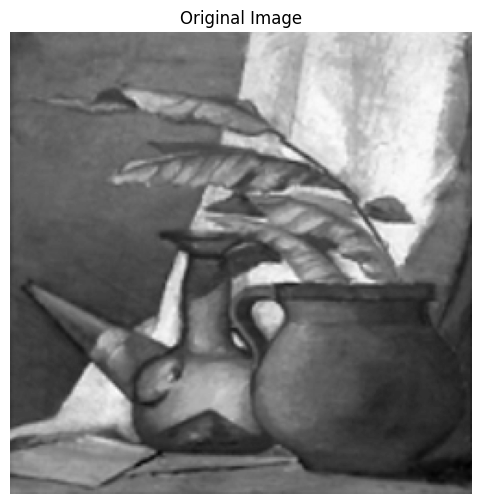

Original Invariants (Orders 1 to 14): [(294634050.6244364+5.173898997254172e-11j), (4294480519812.3413+7.142853762795432e-08j), (7.590123647518446e+16+0.007127564813635995j), (1.5281299956061207e+21-32.24387980432695j), (3.386930948157844e+25+16381529.397593893j), (8.082897236815427e+29-262410938731.16547j), (2.0446279640415716e+34+2.104352937066215e+16j), (5.4181705955952215e+38-2.4063832849159533e+20j), (1.490662145789201e+43+6.05502935087431e+24j), (4.228296810693234e+47-1.7047256861402702e+29j), (1.2298305962568275e+52+3.0843009608020996e+33j), (3.6522527860173125e+56+5.068615089440873e+38j), (1.1036863096969472e+61-4.570835825225733e+42j), (3.3848167342990518e+65-8.103791280568747e+46j)]


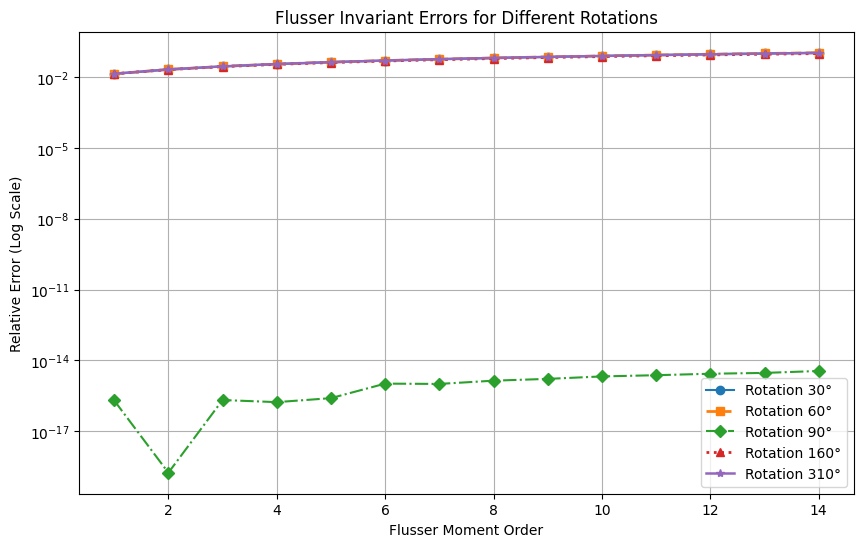

In [95]:
def compute_and_plot_flusser_invariants(image, rotation_angles, max_order=14):
    """
    Compute Flusser invariants for the first `max_order` orders of the image and plot the relative errors
    in a single graph, with one curve per rotation angle. Displays the original image before plotting the graphs.

    Args:
        image: The original input image.
        rotation_angles: A list of rotation angles (in degrees).
        max_order: The number of orders to compute (default is 12).
    """
    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')  # Hide axes for the image
    plt.show()

    # Compute the Flusser invariants for the original image (without transformation) for the first `max_order` orders
    original_flusser_invariants = [compute_flusser_moment(image, order, order) for order in range(1, max_order + 1)]
    print(f"Original Invariants (Orders 1 to {max_order}): {original_flusser_invariants}")

    # Store errors for each rotation angle and order
    errors_rotation = {angle: [] for angle in rotation_angles}

    # Test rotation invariance for different angles and for the first `max_order` orders
    for angle in rotation_angles:
        # Rotate the image by the given angle with padding (black background)
        rotated_image = rotate(image, angle, reshape=True, mode='constant', cval=0)

        # Compute the Flusser invariants for the rotated image for the first `max_order` orders
        for order in range(1, max_order + 1):
            invariant_rotated = compute_flusser_moment(rotated_image, order, order)
            original_invariant = original_flusser_invariants[order - 1]

            # Compute the relative error
            relative_error = np.abs((original_invariant - invariant_rotated) / original_invariant)
            errors_rotation[angle].append(relative_error)

    # Plotting the results: All rotation curves in a single plot
    plt.figure(figsize=(10, 6))

    # Define different styles for lines and markers to distinguish curves better
    line_styles = ['-', '--', '-.', ':', '-']
    markers = ['o', 's', 'D', '^', '*']
    line_widths = [1.5, 2, 1.5, 2, 1.8]

    # Plot each rotation's errors as a curve across moment orders with different styles
    for idx, angle in enumerate(rotation_angles):
        plt.plot(
            range(1, max_order + 1), errors_rotation[angle],
            marker=markers[idx % len(markers)],
            linestyle=line_styles[idx % len(line_styles)],
            linewidth=line_widths[idx % len(line_widths)],
            label=f'Rotation {angle}°'
        )

    # Add labels and title
    plt.xlabel("Flusser Moment Order")
    plt.ylabel("Relative Error (Log Scale)")
    plt.title('Flusser Invariant Errors for Different Rotations')

    # Set y-axis to logarithmic scale
    plt.yscale('log')

    # Add legend to differentiate between rotation angles
    plt.legend()

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.show()

# Example usage:
rotation_angles = [30, 60, 90, 160, 310]


# Call the function to compute and plot
compute_and_plot_flusser_invariants(image, rotation_angles)

Original Invariants: [(294634050.6244364+5.173898997254172e-11j), (4294480519812.3413+7.142853762795432e-08j), (7.590123647518446e+16+0.007127564813635995j), (1.5281299956061207e+21-32.24387980432695j), (3.386930948157844e+25+16381529.397593893j), (8.082897236815427e+29-262410938731.16547j), (2.0446279640415716e+34+2.104352937066215e+16j), (5.4181705955952215e+38-2.4063832849159533e+20j), (1.490662145789201e+43+6.05502935087431e+24j), (4.228296810693234e+47-1.7047256861402702e+29j), (1.2298305962568275e+52+3.0843009608020996e+33j), (3.6522527860173125e+56+5.068615089440873e+38j), (1.1036863096969472e+61-4.570835825225733e+42j), (3.3848167342990518e+65-8.103791280568747e+46j), (1.0512298194753804e+70+1.3115547044806542e+51j), (3.3005154414198763e+74+2.7617262638574004e+56j), (1.0461069019373796e+79-4.956828800468115e+60j), (3.343324895700482e+83+8.647558626331765e+65j), (1.0763991573581288e+88+3.997812106664374e+70j), (3.4882896060095894e+92-6.800046301505692e+73j), (1.1371105241927698e

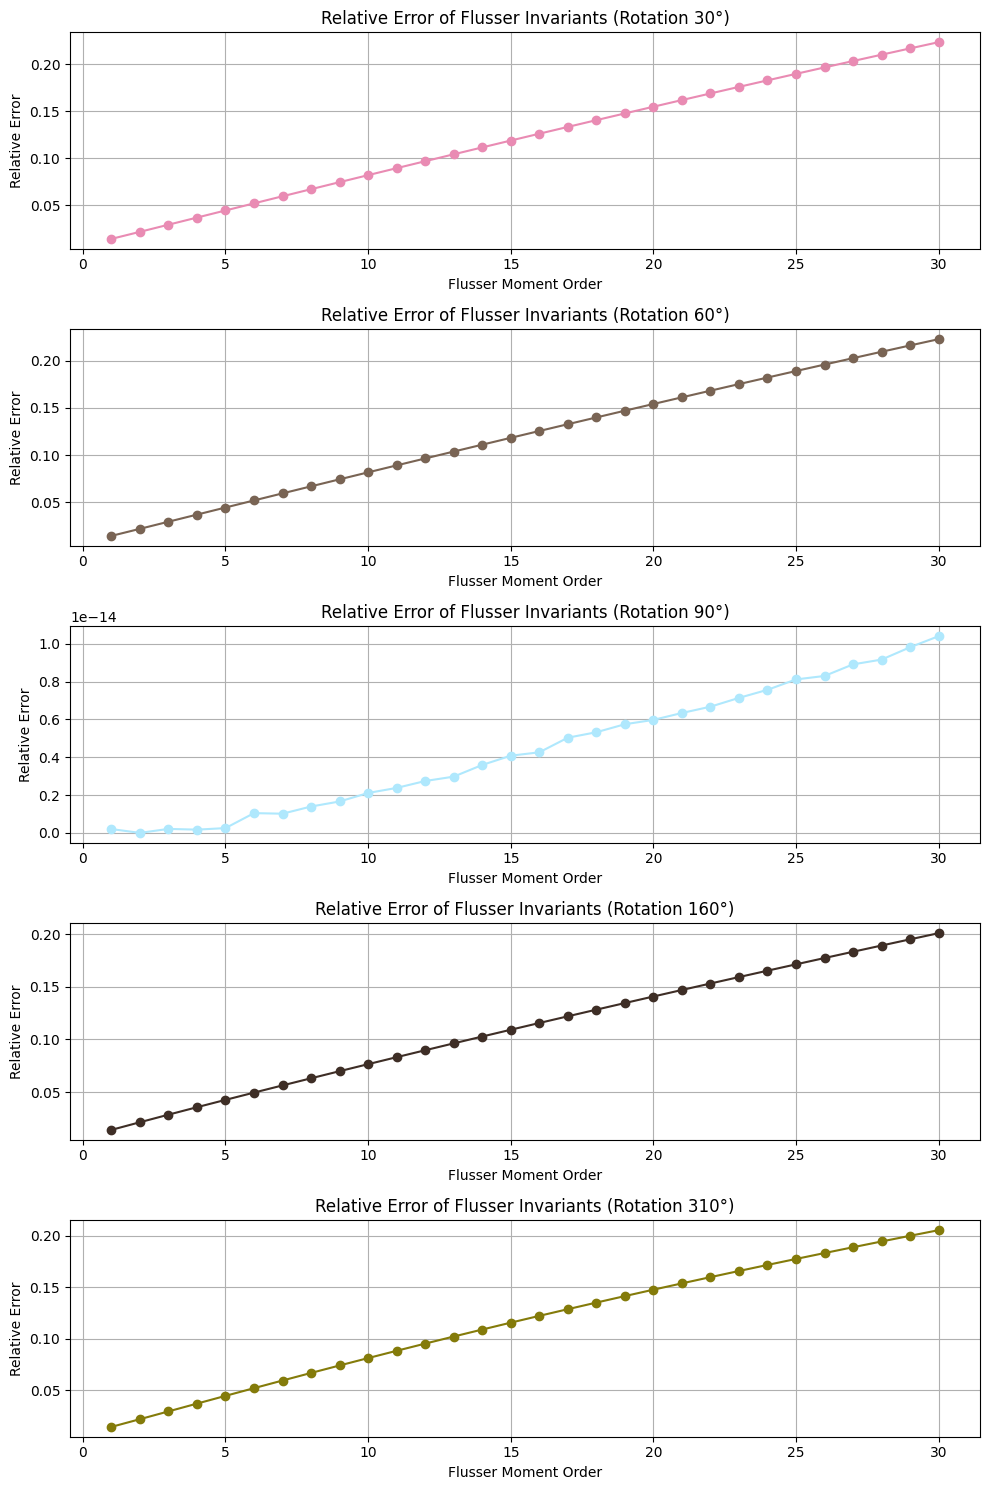

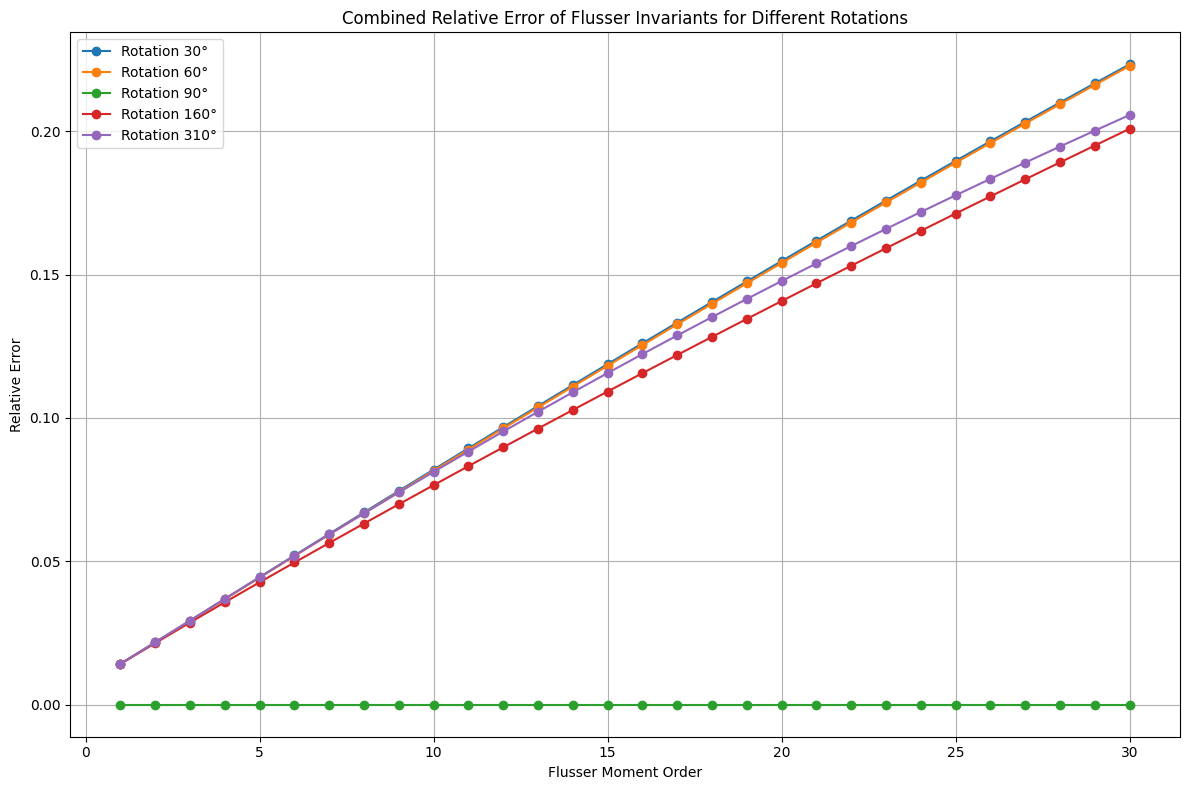

In [100]:
# Define the number of orders to compute (1 to 30)
max_order = 30

# List to store computed invariants and errors for each rotation angle and order
errors_rotation = {angle: [] for angle in rotation_angles}

# Compute the Flusser invariants for the original image for the first 10 orders
original_invariants = [compute_flusser_moment(image, order, order) for order in range(1, max_order + 1)]
print(f"Original Invariants: {original_invariants}")

# Test rotation invariance for different angles and for each order
for angle in rotation_angles:
    # Rotate the image by the given angle with padding (black background)
    rotated_image = rotate(image, angle, reshape=True, mode='constant', cval=0)

    # Compute the Flusser invariants for the rotated image for orders 1 to 10
    for order in range(1, max_order + 1):
        invariant_rot = compute_flusser_moment(rotated_image, order, order)

        # Compute relative error
        original_invariant = original_invariants[order - 1]
        relative_error = np.abs((original_invariant - invariant_rot) / original_invariant)
        errors_rotation[angle].append(relative_error)

# Step 4: Plot separate graphs for each rotation angle
fig, axs = plt.subplots(len(rotation_angles), 1, figsize=(10, 15))

# Plot each graph for a rotation angle
for idx, angle in enumerate(rotation_angles):
    axs[idx].plot(range(1, max_order + 1), errors_rotation[angle], marker='o', linestyle='-', color=np.random.rand(3,))
    axs[idx].set_xlabel("Flusser Moment Order")
    axs[idx].set_ylabel("Relative Error")
    axs[idx].set_title(f"Relative Error of Flusser Invariants (Rotation {angle}°)")
    axs[idx].grid(True)

# Adjust layout for graphs
plt.tight_layout()

# Show all graphs
plt.show()

# Combined plot for all rotation angles
plt.figure(figsize=(12, 8))
for angle in rotation_angles:
    plt.plot(range(1, max_order + 1), errors_rotation[angle], marker='o', linestyle='-', label=f'Rotation {angle}°')

# Add labels and title for the combined graph
plt.xlabel("Flusser Moment Order")
plt.ylabel("Relative Error")
plt.title("Combined Relative Error of Flusser Invariants for Different Rotations")
plt.legend()
plt.grid(True)

# Show the combined plot
plt.tight_layout()
plt.show()

In [101]:
def translate_image(image, tx, ty):
    """ Translate image by (tx, ty) with zero-padding. """
    translated_image = np.zeros_like(image)

    # Define the region where the original image will be copied
    num_rows, num_cols = image.shape
    x_start = max(0, tx)
    y_start = max(0, ty)
    x_end = min(num_cols, num_cols + tx)
    y_end = min(num_rows, num_rows + ty)

    translated_image[y_start:y_end, x_start:x_end] = image[:num_rows - abs(ty), :num_cols - abs(tx)]

    return translated_image


def scale_image(image, scaling_factor):
    """ Scale the image by a factor (zoom in/out). """
    if scaling_factor > 1:
        # Zoom in: enlarge the image
        zoomed_image = zoom(image, scaling_factor)
        # Crop to original size
        center_x = zoomed_image.shape[1] // 2
        center_y = zoomed_image.shape[0] // 2
        crop_x = image.shape[1] // 2
        crop_y = image.shape[0] // 2
        zoomed_image = zoomed_image[center_y - crop_y:center_y + crop_y, center_x - crop_x:center_x + crop_x]

    elif scaling_factor < 1:
        # Zoom out: shrink the image and then pad it to original size
        zoomed_image = zoom(image, scaling_factor)
        # Pad the zoomed image to match the original size
        pad_x = (image.shape[1] - zoomed_image.shape[1]) // 2
        pad_y = (image.shape[0] - zoomed_image.shape[0]) // 2
        zoomed_image = np.pad(zoomed_image, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=0)
        zoomed_image = zoomed_image[:image.shape[0], :image.shape[1]]  # Crop to original size if padding overshoots

    else:
        # scaling_factor == 1, just return the original image
        zoomed_image = image

    return zoomed_image

Translation & Scale trasnformations : NO Invariance with Jan Flusser formulas

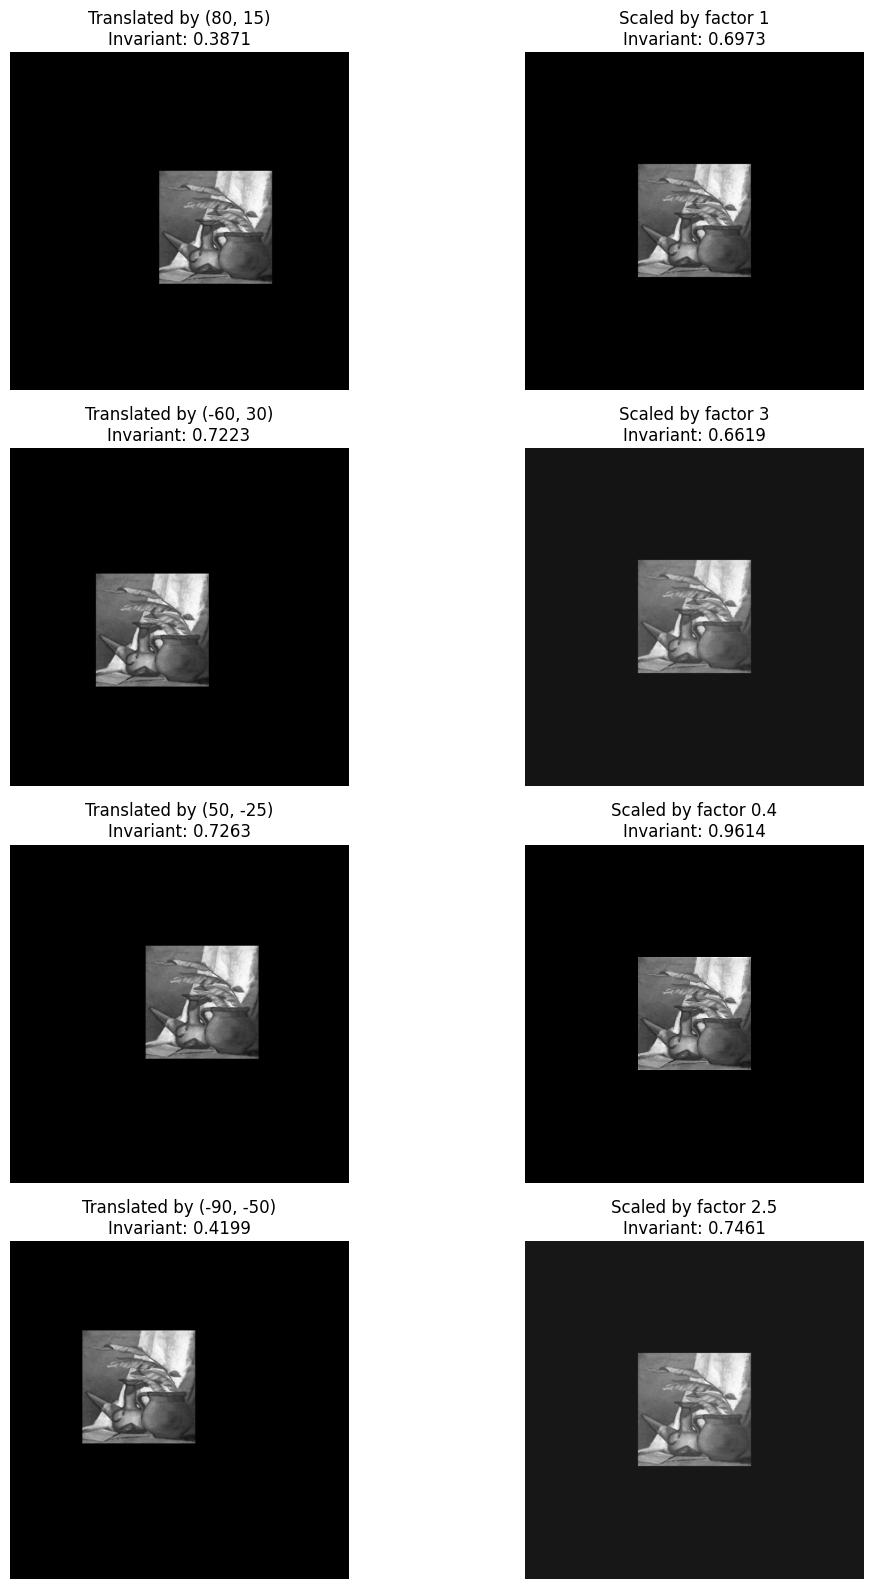

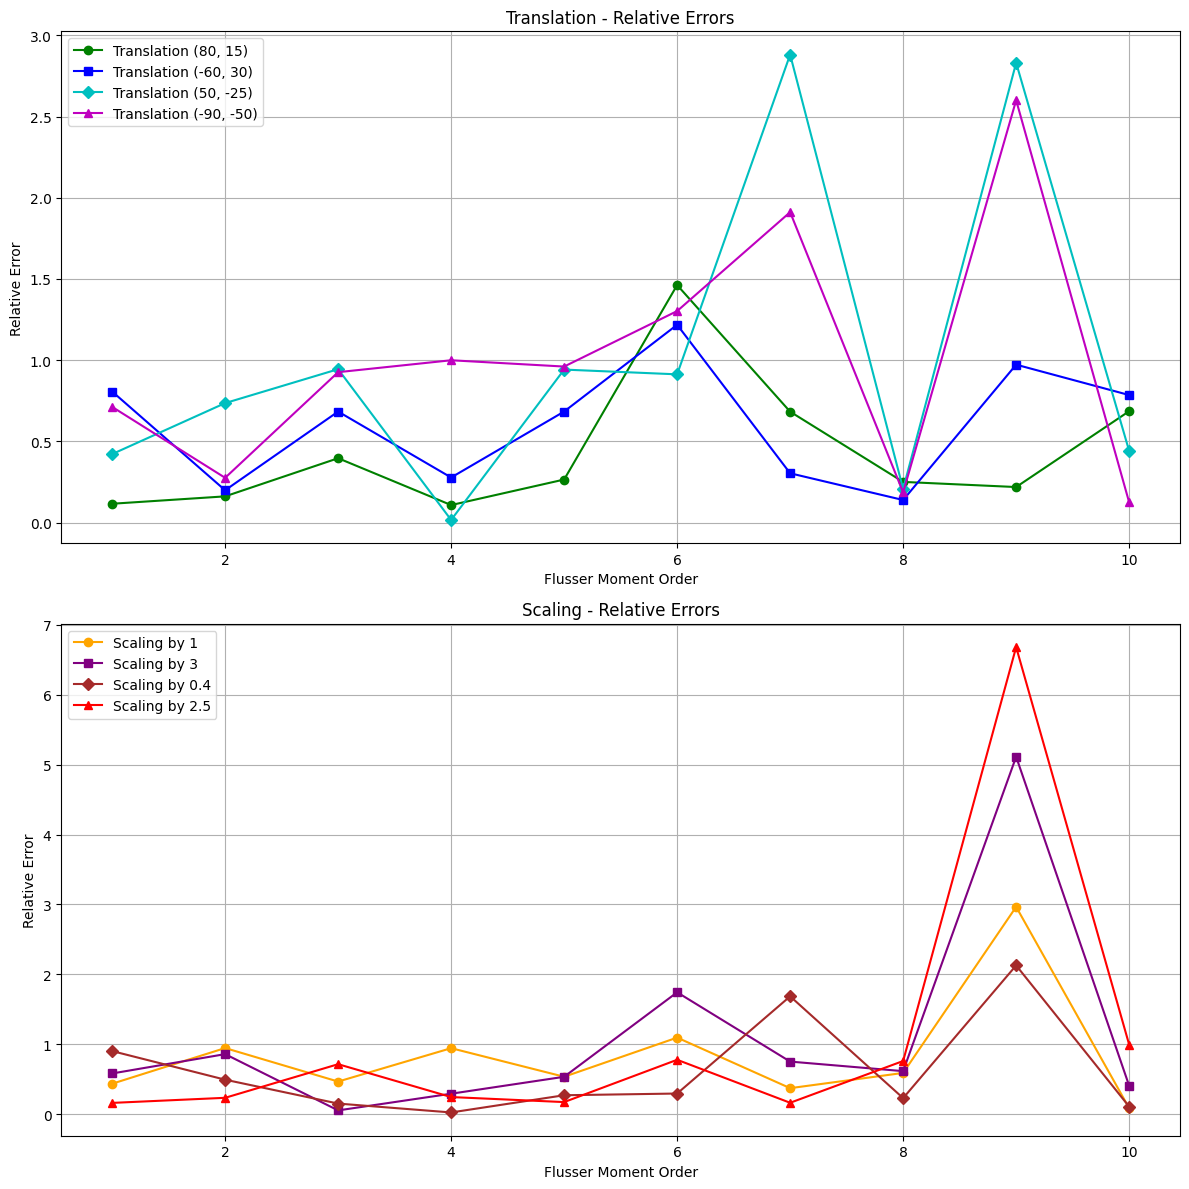

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Function to add padding to the image based on scaling
def add_padding(image, pad_size):
    """
    Add padding around the image.

    Args:
        image: The input image (2D array).
        pad_size: The number of pixels to pad on all sides.

    Returns:
        Padded image with a border of `pad_size` pixels.
    """
    return np.pad(image, pad_size, mode='constant', constant_values=0)  # Padding with zeros (black background)

# Function to translate the image
def translate_image(image, tx, ty):
    """ Translate the image by tx, ty pixels with padding """
    translated_image = np.roll(image, (ty, tx), axis=(0, 1))
    return translated_image

# Function to scale the image
def scale_image(image, scale_factor):
    """ Scale the image by a given factor """
    return zoom(image, scale_factor)

# Function to compute Flusser moment (placeholder, replace with actual implementation)
def compute_flusser_moment(image, p, q):
    """ Placeholder for computing Flusser moment, replace with actual logic """
    return np.random.random()  # Simulating Flusser moment calculation

# Scale parameters (adding more examples)
scaling_factors = [1, 3, 0.4, 2.5]  # 4 examples of scaling

# Determine the maximum scale factor to calculate padding
max_scale = max(scaling_factors)

# Calculate the necessary padding to accommodate the largest scale
image_size = image.shape[0]  # Assuming a square image (250x250)
pad_size = int((max_scale - 1) * image_size / 2)  # Padding relative to the largest scale

# Add padding to ensure the image is fully visible after transformations
padded_image = add_padding(image, pad_size)

# Translation parameters (adding more examples)
translation_params = [(80, 15), (-60, 30), (50, -25), (-90, -50)]  # 4 examples of translation

# Define Flusser moment orders to compute
orders = list(range(1, 11))  # Flusser moment orders from 1 to 10

# Compute the Flusser invariants for the original image (without transformation)
original_invariants = [compute_flusser_moment(image, p, p) for p in orders]

# Relative error computation for translations and scaling
errors_translation = []
errors_scaling = []
invariant_values_translation = []
invariant_values_scaling = []

# Test translation
for tx, ty in translation_params:
    translated_image = translate_image(padded_image, tx, ty)
    invariant_trans = compute_flusser_moment(translated_image, 12, 12)  # p=12, q=12
    invariant_values_translation.append(invariant_trans)

    relative_errors = [
        np.abs((compute_flusser_moment(translated_image, p, p) - original_invariants[p - 1]) / original_invariants[p - 1])
        for p in orders
    ]
    errors_translation.append(relative_errors)

# Test scaling
for scale in scaling_factors:
    scaled_image = scale_image(padded_image, scale)
    invariant_scale = compute_flusser_moment(scaled_image, 10, 10)  # Using p=10, q=10
    invariant_values_scaling.append(invariant_scale)

    relative_errors = [
        np.abs((compute_flusser_moment(scaled_image, p, p) - original_invariants[p - 1]) / original_invariants[p - 1])
        for p in orders
    ]
    errors_scaling.append(relative_errors)

# Display Transformed Images (2 per row)
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Plot translated images with invariant values
for idx, (tx, ty) in enumerate(translation_params):
    translated_image = translate_image(padded_image, tx, ty)
    axs[idx, 0].imshow(translated_image, cmap='gray')
    axs[idx, 0].set_title(f"Translated by ({tx}, {ty})\nInvariant: {invariant_values_translation[idx]:.4f}")
    axs[idx, 0].axis('off')

# Plot scaled images with invariant values
for idx, scale in enumerate(scaling_factors):
    scaled_image = scale_image(padded_image, scale)
    axs[idx, 1].imshow(scaled_image, cmap='gray')
    axs[idx, 1].set_title(f"Scaled by factor {scale}\nInvariant: {invariant_values_scaling[idx]:.4f}")
    axs[idx, 1].axis('off')

# Adjust layout for all images
plt.tight_layout()
plt.show()

# Now plot the Flusser relative error graphs
fig, axs = plt.subplots(2, 1, figsize=(12, 12))  # 2 rows for translation and scaling

# Define different colors for each transformation
translation_colors = ['g', 'b', 'c', 'm']  # Different colors for translations
scaling_colors = ['orange', 'purple', 'brown', 'red']  # Different colors for scaling

# Plot translation graphs (regular scale) with different motifs and colors
markers = ['o', 's', 'D', '^']  # Different motifs for each translation
for idx, (tx, ty) in enumerate(translation_params):
    axs[0].plot(orders, errors_translation[idx], marker=markers[idx], linestyle='-', color=translation_colors[idx],
                label=f'Translation ({tx}, {ty})')

axs[0].set_title("Translation - Relative Errors")
axs[0].set_xlabel("Flusser Moment Order")
axs[0].set_ylabel("Relative Error")
axs[0].grid(True)
axs[0].legend()

# Plot scaling graphs (regular scale) with different motifs and colors
for idx, scale in enumerate(scaling_factors):
    axs[1].plot(orders, errors_scaling[idx], marker=markers[idx], linestyle='-', color=scaling_colors[idx],
                label=f'Scaling by {scale}')

axs[1].set_title("Scaling - Relative Errors")
axs[1].set_xlabel("Flusser Moment Order")
axs[1].set_ylabel("Relative Error")
axs[1].grid(True)
axs[1].legend()

# Adjust layout for all plots
plt.tight_layout()

# Show all plots
plt.show()


## 2. Ghorbel Complex Invariants

In [121]:
def compute_complex_moments(image, p, q):
    """ Compute complex moments for the image with translation invariance (center of mass). """
    rows, cols = image.shape

    # Compute center of mass (translation invariance)
    y, x = np.indices((rows, cols))
    m00 = np.sum(image)  # Sum of image intensity
    m10 = np.sum(x * image)  # First moment along x
    m01 = np.sum(y * image)  # First moment along y
    x_bar = m10 / m00  # Center of mass x
    y_bar = m01 / m00  # Center of mass y

    # Shift coordinates to center of mass
    X_shifted = x - x_bar
    Y_shifted = y - y_bar

    # Compute complex moments
    return np.sum((X_shifted + 1j * Y_shifted)**p * image * (X_shifted - 1j * Y_shifted)**q)

def nth_root_complex(z, n):
    """ Calculate the n-th root of a complex number z. """
    r = np.abs(z)  # Magnitude
    theta = np.angle(z)  # Phase angle

    # Calculate the n-th root using De Moivre's theorem
    root_magnitude = r ** (1/n)
    root_angle = theta / n
    return root_magnitude * (np.cos(root_angle) + 1j * np.sin(root_angle))

def compute_ghorbel_invariant(image, p, q, p0=2, p1=2):
    """ Compute Faouzi Ghorbel's invariants for an image. """

    # Compute the complex moment for (p1, p1)
    c_f_p1_p1 = compute_complex_moments(image, p1, p1)  # c_f(p1, p1)
    Gamma_f = np.abs(c_f_p1_p1)**(1 / (2 * (p1 + 1)))  # Gamma_f as nth root of c_f(p1,p1)

    c_f_p0_1_p0 = compute_complex_moments(image, p0 - 1, p0)  # c_f(p0-1, p0)
    Theta_f = -np.angle(c_f_p0_1_p0)  # Theta_f = -arg(c_f(p0-1, p0))



    # Calculate Ghorbel invariant
    ghorbel_invariant = (Gamma_f**(-(p + q + 2)))*(np.exp(-1j * (p - q) * Theta_f))*(compute_complex_moments(image, p, q))

    return ghorbel_invariant


p0 = 5
p1 = 5

c_f_p1_p1 = compute_complex_moments(image, p1, p1)

print(c_f_p1_p1)

print(compute_ghorbel_invariant(image, 5, 5))


(3.386930948157844e+25+16381529.397593893j)
(1.8364752014598995+8.882458178555539e-19j)


In [117]:
# Compute normalization factors
c_f_0_0 = compute_complex_moments(image, 0, 0)  # c_f(0, 0)

Rotation | Translation | Scaling

Original Ghorbel Invariants (Order 5): 1.8365-0.0000j


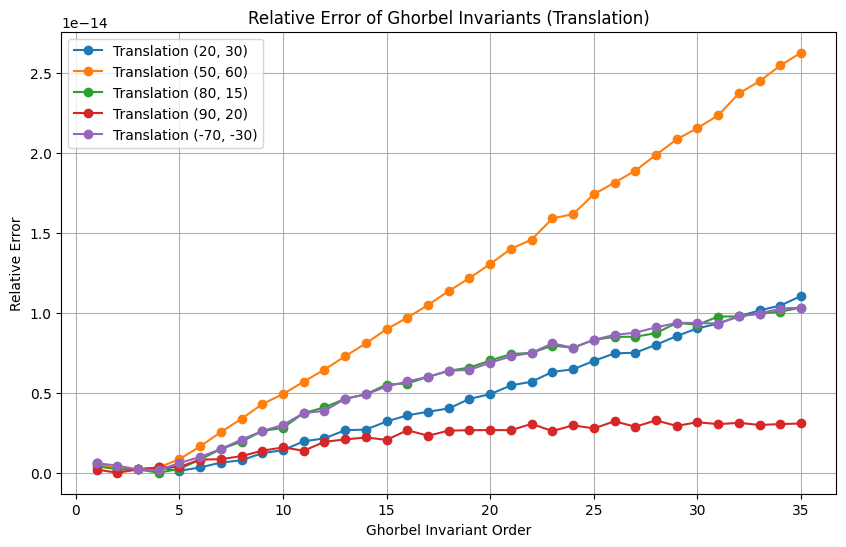

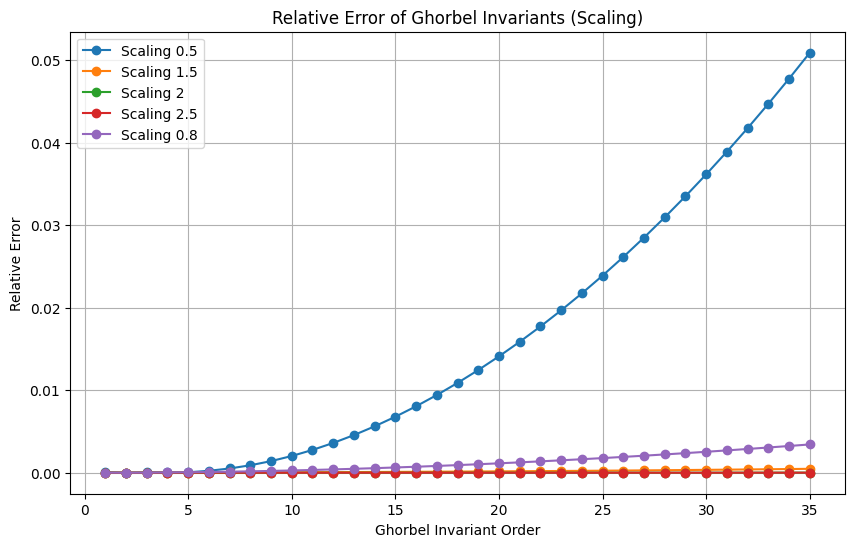

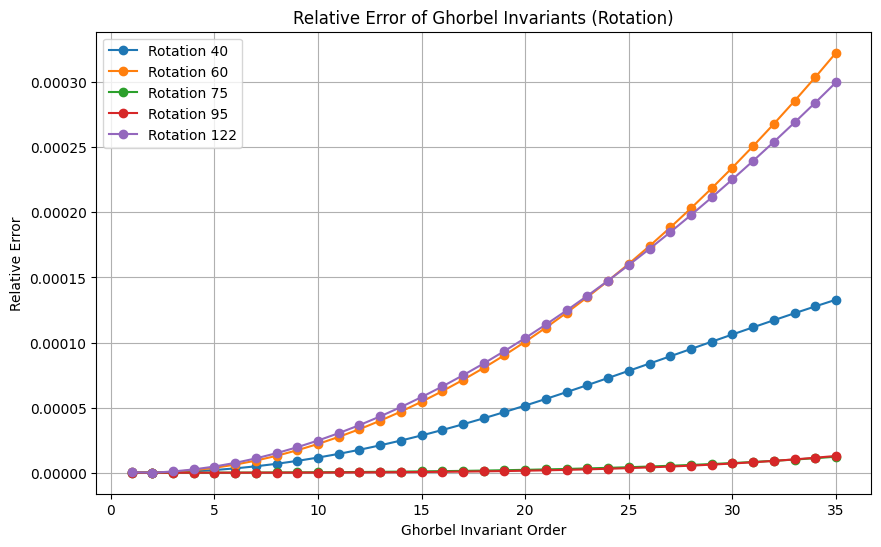

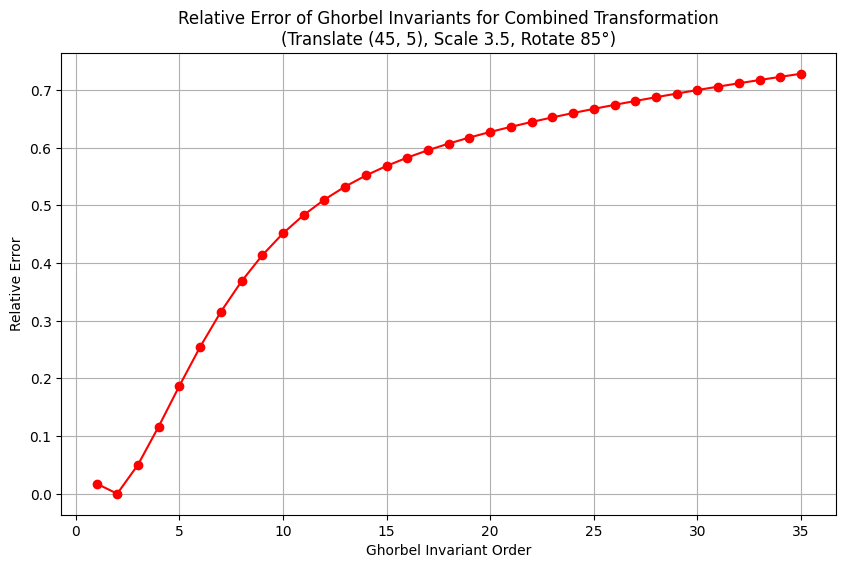

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, zoom
from skimage import io

# Function to add padding to the image
def add_padding(image, pad_size):
    """Add padding around the image."""
    return np.pad(image, pad_size, mode='constant', constant_values=0)

# Function to translate the image
def translate_image(image, tx, ty):
    """Translate the image by tx, ty pixels."""
    return np.roll(image, (ty, tx), axis=(0, 1))

# Function to scale the image
def scale_image(image, scale_factor):
    """Scale the image by a given factor."""
    return zoom(image, scale_factor)

# Add padding to ensure image is fully visible after transformations
pad_size = 100
padded_image = add_padding(image, pad_size)

# Define transformation parameters
translation_offsets = [(20, 30), (50, 60), (80, 15), (90, 20), (-70, -30)]  # 5 examples of translation
scaling_factors = [0.5, 1.5, 2, 2.5, 0.8]  # 5 examples of scaling
rotation_angles = [40, 60, 75, 95, 122]  # 5 examples of rotation

# Function to compute Ghorbel invariants for multiple orders
def compute_ghorbel_invariants(image, max_order=35):
    """Compute Ghorbel invariants from order 1 to `max_order`."""
    return [compute_ghorbel_invariant(image, p, p) for p in range(1, max_order + 1)]

# Store Ghorbel invariants and errors
errors_translation_ghorbel = []
errors_scaling_ghorbel = []
errors_rotation_ghorbel = []

# Compute the Ghorbel invariants for the original image (without transformation)
original_ghorbel_invariants = compute_ghorbel_invariants(padded_image, max_order=35)
print(f"Original Ghorbel Invariants (Order 5): {original_ghorbel_invariants[4]:.4f}")

# Test translation invariance for different offsets
for tx, ty in translation_offsets:
    translated_image = translate_image(padded_image, tx, ty)
    translated_invariants = compute_ghorbel_invariants(translated_image, max_order=35)

    # Compute relative errors for translation
    relative_errors_translation = [
        np.abs((original - translated) / original) for original, translated in zip(original_ghorbel_invariants, translated_invariants)
    ]
    errors_translation_ghorbel.append(relative_errors_translation)

# Test scaling for different factors
for scale in scaling_factors:
    scaled_image = scale_image(padded_image, scale)
    scaled_invariants = compute_ghorbel_invariants(scaled_image, max_order=35)

    # Compute relative errors for scaling
    relative_errors_scaling = [
        np.abs((original - scaled) / original) for original, scaled in zip(original_ghorbel_invariants, scaled_invariants)
    ]
    errors_scaling_ghorbel.append(relative_errors_scaling)

# Test rotation invariance for different angles
for angle in rotation_angles:
    rotated_image = rotate(padded_image, angle, reshape=True, mode='constant', cval=0)
    rotated_invariants = compute_ghorbel_invariants(rotated_image, max_order=35)

    # Compute relative errors for rotation
    relative_errors_rotation = [
        np.abs((original - rotated) / original) for original, rotated in zip(original_ghorbel_invariants, rotated_invariants)
    ]
    errors_rotation_ghorbel.append(relative_errors_rotation)

# Plotting the relative error graphs (3 separate plots for translation, scaling, and rotation)
orders = list(range(1, 36))  # Ghorbel Invariant Orders 1 to 35

def plot_relative_errors(errors, title, xlabel, transformations, transformation_type):
    """Helper function to plot relative errors for a given transformation."""
    plt.figure(figsize=(10, 6))

    # Plot each transformation's relative errors
    for i, error in enumerate(errors):
        plt.plot(orders, error, marker='o', label=f'{transformation_type} {transformations[i]}')

    plt.xlabel(xlabel)
    plt.ylabel('Relative Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot relative error for translation
plot_relative_errors(
    errors_translation_ghorbel,
    "Relative Error of Ghorbel Invariants (Translation)",
    "Ghorbel Invariant Order",
    translation_offsets,
    "Translation"
)

# Plot relative error for scaling
plot_relative_errors(
    errors_scaling_ghorbel,
    "Relative Error of Ghorbel Invariants (Scaling)",
    "Ghorbel Invariant Order",
    scaling_factors,
    "Scaling"
)

# Plot relative error for rotation
plot_relative_errors(
    errors_rotation_ghorbel,
    "Relative Error of Ghorbel Invariants (Rotation)",
    "Ghorbel Invariant Order",
    rotation_angles,
    "Rotation"
)

# Combined transformation example: Translate (45, 5), Scale (3.5), Rotate (85)
tx, ty = 45, 5
scale_factor = 3.5
rotation_angle = 85

# Apply transformations
combined_image = rotate(scale_image(translate_image(image, tx, ty), scale_factor), rotation_angle)

# Compute the Ghorbel invariants for the combined transformation
combined_invariants = compute_ghorbel_invariants(combined_image, max_order=35)

# Compute relative errors for the combined transformation
combined_relative_errors = [
    np.abs((original - combined) / original) for original, combined in zip(original_ghorbel_invariants, combined_invariants)
]

# Plot the combined transformation error graph
plt.figure(figsize=(10, 6))
plt.plot(orders, combined_relative_errors, marker='o', color='r')
plt.xlabel("Ghorbel Invariant Order")
plt.ylabel("Relative Error")
plt.title(f"Relative Error of Ghorbel Invariants for Combined Transformation\n(Translate ({tx}, {ty}), Scale {scale_factor}, Rotate {rotation_angle}°)")
plt.grid(True)
plt.show()
